In [ ]:
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.optimize as opt
import numpy as np
import csv
from google.colab import files
from google.colab import drive




Mounted at /content/drive


In [ ]:
#first import all the envoronmental data and clean the data

data_2020 = pd.read_csv('weather_weybourne_2020.csv',sep=',', skiprows= 280, header ='infer',skipfooter =1)
data_2021 = pd.read_csv('weather_weybourne_2021.csv',sep=',', skiprows= 280, header ='infer',skipfooter =1)
data_2020_int = data_2020[['ob_time','air_temperature']]
data_2021_int = data_2021[['ob_time','air_temperature']]
data = data_2020_int.append(data_2021_int,ignore_index=True)
data.loc[:,'ob_time'] = pd.to_datetime(data.loc[:,'ob_time'],errors='raise', format ='%Y/%m/%d %H:%M:%S')
data = data.set_index('ob_time')

<ipython-input-3-7d3e51babb5f>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data_2020 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Blakeney_project/Climate_data_blakeney/weather_weybourne_2020.csv',sep=',', skiprows= 280, header ='infer',skipfooter =1)
<ipython-input-3-7d3e51babb5f>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data_2021 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Blakeney_project/Climate_data_blakeney/weather_weybourne_2021.csv',sep=',', skiprows= 280, header ='infer',skipfooter =1)


AttributeError: 'DataFrame' object has no attribute 'concat'

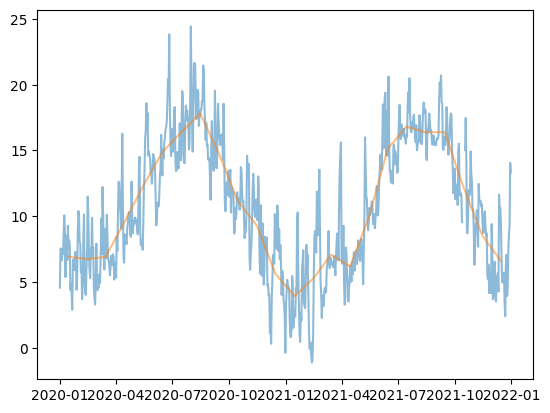

In [ ]:
from re import subn

T_1day = data.groupby(pd.Grouper(freq="1D")).mean()
T_month = data.groupby(pd.Grouper(freq="1M")).mean()
T_month.index=T_month.index.map(lambda x : x.replace(day=15))
#group by automatically assign value to the last day of the month

#plt.scatter(data.index, data['air_temperature'], s = 1,alpha = 0.1)
plt.plot(T_1day.index, T_1day['air_temperature'], alpha = 0.5)
plt.plot(T_month.index, T_month['air_temperature'], alpha = 0.5)


In [ ]:

T_month
T_month.to_excel("Monthly_T.xlsx")

12.725
13.520833333333334
14.679166666666667
13.595833333333333
13.545833333333334
15.762500000000001
18.491666666666667
15.166666666666666
18.054166666666667
19.075
19.391666666666666
14.608333333333334
15.704166666666666
18.0


KeyboardInterrupt: 

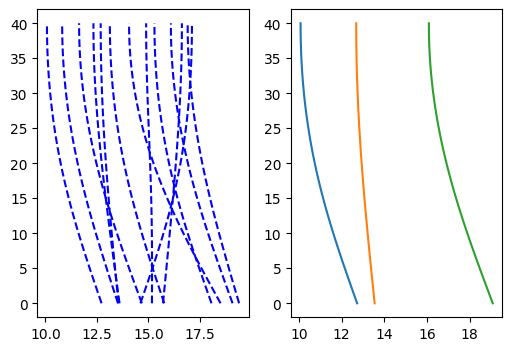

In [ ]:
#set model parameters and store data, model is run for 1 month
#thermal diffusion
#dT/dt = K d(dT)/dx*dx)
#in the case when T shifts from cold to warm, use data from 2021-5 (average = 9.8)(2021-May1 to 2021-May-31) to 2021-06 (2021-June-01 to June) average (14.9)

average_May21 = 9.8 #deg C
T_June21 = T_1day.loc['2021-06-01':'2021-06-30','air_temperature']
T_June21v = T_June21.values #only get T_June21 values (no index) and store in T_June21v
T_June21v

K = 7900/30/3*2 #cm^2/day   thermal diffus for porosity at 0.90
col_dep = 40 #cm
duration =  1#  day 2.59e6s = 1 month*30 d/m *24 h/d *60min/h *60s/h
space_resolution = 100
time_resolution = 10000
dx = col_dep/space_resolution #cm
dt = duration/ time_resolution #month

#first create a disctionary to store model results
T_results = pd.DataFrame()
T_initial = np.ones(space_resolution)* average_May21 #The initial condition is the average of

depth = {'dep': np.linspace(0,40,100)}


fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 4))
# set initial value to be equal to average T

a = 0 #count which month is the model
for i in T_June21.values:
  print(i)
  #set the intial value to be result of previous month
  if a > 0:
    T_initial = T
  for t in range(time_resolution-1): #loop through the time step
    if t == 0:
      T = T_initial
    for x in range(space_resolution-1): #loop through the space step
      if x == 0:
        T[x] = i
      elif x == space_resolution-2: #temperature diffuse up:
        T[x] = T[x] + K*((T[x+1]-2*T[x]+T[x-1])/(dx**2)) * dt
      else:  #temperature diffuse down:
        T[x] = T[x] + K*((T[x-1]-2*T[x]+T[x+1])/(dx**2)) * dt
      T[-1] = T[-2]
      mask = T > 1e-30
      T = T * (np.ones(len(T)) * mask) + 1e-30
  ax[0].plot(T[range(space_resolution)],depth['dep'],label = f'{a} day',color = 'b', linestyle = '--' )
  if a == 0:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')
  if a == 4:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')
  if a == 9:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')
  if a == 29:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')

  #store dict data into dataframe
  T_results[a+1] =  T
  a = a+1


ax[0].set_xlim(0,25)
ax[0].set_ylim(0,40)
ax[1].set_xlim(0,25)
ax[1].set_ylim(0,40)

ax[0].set_ylabel('Depth (cm)')
ax[1].set_ylim(0,40)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#store the final data in results_10day
#results_1month
T_results
T_results['mean'] = T_results.mean(axis=1)
ax[0].plot(T_results['mean'],T_results.index,color = 'r',linewidth=2)

In [ ]:
#set model parameters and store data, model is run for 1 month
#thermal diffusion
#dT/dt = K d(dT)/dx*dx)
#in the case when T shifts from hot to cold, use data from 2021-9 (average = 16.4)(2021-Sept1 to 2021-Sept-31) to 2021-10 (2021-Oct-01 to Oct30) average (12.3)

average_Sept21 = 16.4 #deg C
T_Oct21 = T_1day.loc['2021-10-01':'2021-10-30','air_temperature']
T_Oct21v = T_Oct21.values #only get T_June21 values (no index) and store in T_June21v
T_Oct21v

K = 7900/30/3*2 #cm^2/day   thermal diffus for porosity at 0.90
col_dep = 40 #cm
duration =  1#  day 2.59e6s = 1 month*30 d/m *24 h/d *60min/h *60s/h
space_resolution = 100
time_resolution = 10000
dx = col_dep/space_resolution #cm
dt = duration/ time_resolution #month
#first create a disctionary to store model results
#T_results = {i: np.ones(space_resolution) * 1e-12 for i in range(30)}
T_results_cw = pd.DataFrame()
T_initial = np.ones(space_resolution)* average_Sept21 #The initial condition is the average of

depth = {'dep': np.linspace(0,40,100)}


fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 4))
# set initial value to be equal to average T


a = 0 #count which month is the model
for i in T_Oct21.values:
  print(i)
  #set the intial value to be result of previous month
  if a > 0:
    T_initial = T
  for t in range(time_resolution-1): #loop through the time step
    if t == 0:
      T = T_initial
    for x in range(space_resolution-1): #loop through the space step
      if x == 0:
        T[x] = i
        if np.isnan(T[0]) == True:
          #if no value for surface T, surface T is the same as the value from the day before
          T[x] = T_initial[1]
          print(T[x])
      elif x == space_resolution-2: #temperature diffuse up:
        T[x] = T[x] + K*((T[x+1]-2*T[x]+T[x-1])/(dx**2)) * dt
      else:  #temperature diffuse down:
        T[x] = T[x] + K*((T[x-1]-2*T[x]+T[x+1])/(dx**2)) * dt
      T[-1] = T[-2]
      #mask = T > 1e-30
      #T = T * (np.ones(len(T)) * mask) + 1e-30
  ax[0].plot(T[range(space_resolution)],depth['dep'],label = f'{a} day',color = 'b', linestyle = '--' )
  if a == 0:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')
  if a == 4:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')
  if a ==9:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')
  if a == 29:
    ax[1].plot(T[range(space_resolution)],depth['dep'],label = f'{a+1} day')

  #store dict data into dataframe
  T_results_cw[a+1] =  T
  a = a+1


ax[0].set_xlim(0,25)
ax[0].set_ylim(0,40)
ax[1].set_xlim(0,25)
ax[1].set_ylim(0,40)

ax[0].set_ylabel('Depth (cm)')
ax[1].set_ylim(0,40)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#store the final data in results_10day
#results_1month
T_results_cw
T_results_cw['mean'] = T_results_cw.mean(axis=1)
ax[0].plot(T_results_cw['mean'],T_results_cw.index,color = 'r',linewidth=2)

In [ ]:
T_Oct21v.isnull()

In [ ]:
# compute row averages using the mean() method
T_results['mean'] = T_results.mean(axis=1)
T_results.to_csv('T_results_May_to_June.csv')
files.download('T_results_May_to_June.csv')

In [ ]:
T_results_cw['mean'] = T_results_cw.mean(axis=1)
T_results_cw.to_csv('T_results_Sept_to_Oct.csv')
files.download('T_results_Sept_to_Oct.csv')

In [ ]:
T_results = pd.read_csv('T_results_May_to_June.csv')
T_results_cw = pd.read_csv('T_results_Sept_to_Oct.csv')
fig,ax = plt.subplots(nrows = 3, ncols = 2, figsize = (6, 10))
depth = {'dep': np.linspace(0,40,100)}

#plot the first column as May to June
T_May = np.zeros(100)+9.8
a = 0
cmap = plt.get_cmap('coolwarm', 40)
for i in T_results.columns[1:-2]:
    a = a+1
    ax[2,0].plot(T_results[i],depth['dep'],color = cmap(a), linestyle = '--' )
ax[1,0].plot(T_May, depth['dep'],label = 'May average',color = 'k',linewidth=2)
ax[1,0].plot(T_results['1'],depth['dep'],label = f'{1} day, June',color = cmap(1))
ax[1,0].plot(T_results['5'],depth['dep'],label = f'{5} days, June',color = cmap(5))
ax[1,0].plot(T_results['10'],depth['dep'],label = f'{10} days, June',color = cmap(10))
ax[1,0].plot(T_results['30'],depth['dep'],label = f'{30} days, June',color = cmap(30))
ax[1,0].set_xlim(5,25)
ax[1,0].set_ylim(0,40)
ax[1,0].set_ylim(0,40)


ax[1,0].plot(T_results['mean'],depth['dep'],label = 'June average (Model)',color = 'r',linewidth=2)
ax[2,0].plot(T_results['mean'],depth['dep'],label = 'June average (Model)',color = 'r',linewidth=2)
ax[2,0].plot(T_May, depth['dep'],label = 'May average',color = 'k',linewidth=2)

ax[2,0].set_xlim(5,25)
ax[2,0].set_ylim(0,40)

ax[2,0].invert_yaxis()
T_1day = data.groupby(pd.Grouper(freq="1D")).mean()
T_month = data.groupby(pd.Grouper(freq="1M")).mean()
T_month.index=T_month.index.map(lambda x : x.replace(day=15))
#plt.scatter(data.index, data['air_temperature'], s = 1,alpha = 0.1)
#ax[0,0].plot(T_1day['air_temperature'],T_1day.index,  alpha = 0.5, c = 'orange')
#ax[0,0].plot(T_month['air_temperature'],T_month.index,  alpha = 0.5, label = 'monthly average')
ax[0,0].plot(T_June21,T_June21.index,c = 'b',label = 'June daily')
ax[0,0].scatter(9.8,pd.to_datetime('2021-05-15'),c ='k',label = 'May average')
ax[0,0].scatter(14.9,pd.to_datetime('2021-06-15'), c ='r',label = 'June average')
ax[0,0].set_xlim(5,25)
ax[0,0].set_ylim(pd.to_datetime('2021-05-01'),pd.to_datetime('2021-06-30'))

ax[0,0].set_yticks(ticks =[pd.to_datetime('2021-05-15'),pd.to_datetime('2021-06-15')],labels = ['2021-05','2021-06'] )


#plot the second column as Sept to Oct

T_Sept = np.zeros(100)+16.2
a = 0
cmap = plt.get_cmap('Blues_r', 40)
for i in T_results_cw.columns[1:-2]:
    a = a+1
    ax[2,1].plot(T_results_cw[i],depth['dep'],color = cmap(a), linestyle = '--')
    ax[2,1].set_label('daily')
ax[1,1].plot(T_Sept, depth['dep'],label = 'September average',color = 'k',linewidth=2)
ax[1,1].plot(T_results_cw['1'],depth['dep'],label = f'{1} day, October',color = cmap(1))
ax[1,1].plot(T_results_cw['5'],depth['dep'],label = f'{5} days, October',color = cmap(5))
ax[1,1].plot(T_results_cw['10'],depth['dep'],label = f'{10} days, October',color = cmap(10))
ax[1,1].plot(T_results_cw['30'],depth['dep'],label = f'{30} days, October',color = cmap(30))
ax[1,1].set_xlim(5,25)
ax[1,1].set_ylim(0,40)
ax[1,1].plot(T_results_cw['mean'],depth['dep'],label = 'October average(Model)',color = 'r',linewidth=2)
ax[2,1].plot(T_results_cw['mean'],depth['dep'],label = 'October average(Model)',color = 'r',linewidth=2)
ax[2,1].plot(T_Sept, depth['dep'],label = 'September average',color = 'k',linewidth=2)
ax[2,1].set_xlim(5,25)
ax[2,1].set_ylim(0,40)


T_1day = data.groupby(pd.Grouper(freq="1D")).mean()
T_month = data.groupby(pd.Grouper(freq="1M")).mean()
T_month.index=T_month.index.map(lambda x : x.replace(day=15))
#plt.scatter(data.index, data['air_temperature'], s = 1,alpha = 0.1)
#ax[0,0].plot(T_1day['air_temperature'],T_1day.index,  alpha = 0.5, c = 'orange')
#ax[0,1].plot(T_month['air_temperature'],T_month.index,  alpha = 0.5,label = 'Monthly average')
ax[0,1].plot(T_Oct21,T_Oct21.index,c = 'b', label = 'October daily')
ax[0,1].scatter(16.4,pd.to_datetime('2021-09-15'),c ='k', label = 'September average')
ax[0,1].scatter(12.3,pd.to_datetime('2021-10-15'), c ='r',label = 'October average')
ax[0,1].set_xlim(5,25)
ax[0,1].set_ylim(pd.to_datetime('2021-09-01'),pd.to_datetime('2021-10-30'))

ax[0,1].set_yticks(ticks =[pd.to_datetime('2021-09-15'),pd.to_datetime('2021-10-15')],labels = ['2021-09','2021-10'] )
ax[2,0].scatter(14.9, 0,label = 'June average',color = 'r',s =20)
ax[2,1].scatter(12.3, 0,label = 'October average',color = 'r',s =20)
ax[2,0].set_ylim([-1, 40])
ax[2,1].set_ylim([-1, 40])
for ho in ax:
  for a in ho:
    a.xaxis.tick_top()
    a.invert_yaxis()
    a.set_ylabel('Depth (cm)')

ax[0,0].set_ylabel('Date')
ax[0,1].set_ylabel('Date')
ax[2,0].legend(loc='lower right',fontsize = 8)
ax[1,0].legend(loc='lower right',fontsize = 8)
ax[0,0].legend(loc='upper right',fontsize = 8)
ax[0,1].legend(loc='upper right',fontsize = 8)
ax[1,1].legend(loc='lower right',fontsize = 8)
ax[2,1].legend(loc='lower right',fontsize = 8)
plt.tight_layout()

plt.savefig("T_model_sasha.pdf", format="pdf", dpi=600)
files.download("T_model_sasha.pdf")